# Prediction of Drought Levels in California based on GHCND Data

### Author: Fan Hu

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import matplotlib.dates as mdates

# plt.style.use('fivethirtyeight')

# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import folium
import folium.plugins
from IPython.display import display, Latex, Markdown

from sklearn import linear_model
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(23)

## Data Sampling and Collection

### Dataset 1: Daily Global Weather 2020 ###

Import the provided `daily_global_weather_2020.csv` and check the data structure.

In [2]:
global_weather_2020 = pd.read_csv('data/daily_global_weather_2020.csv', header=0, index_col=[0]) 
global_weather_2020.head()

,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
0,AE000041196,2020-01-01,211.0,25.333,55.5170,34.0,0.0
1,AEM00041194,2020-01-01,217.0,25.255,55.3640,10.4,0.0
2,AFM00040938,2020-01-01,54.0,34.210,62.2280,977.2,23.0
3,AG000060611,2020-01-01,71.0,28.050,9.6331,561.0,10.0
4,AGE00147708,2020-01-01,99.0,36.720,4.0500,222.0,0.0


In [3]:
# Get the information of all stations & plot the locations on a map: 

print('The total number of global stations on record for 2020 is:', 
      len(global_weather_2020['Station'].value_counts()))

all_stations_2020 = global_weather_2020[['Station', 'Latitude', 'Longitude', 'Elevation']].groupby('Station').first()

# COORDINATES = (50, 0)
# cluster = folium.plugins.MarkerCluster()
# for _, r in all_stations_2020[['Latitude', 'Longitude', 'Elevation']].dropna().iterrows():
#     cluster.add_child(
#         folium.Marker([float(r["Latitude"]), float(r["Longitude"])], popup=r['Elevation']))
    
# world_map = folium.Map(location=COORDINATES, zoom_start=2)
# world_map.add_child(cluster)

# display(world_map)

The total number of global stations on record for 2020 is: 4970


In [4]:
# Select US data and get all US stations

us_weather_2020 = global_weather_2020[global_weather_2020['Station'].str.startswith('US')]
us_stations_2020 = us_weather_2020[['Station', 'Latitude', 'Longitude', 'Elevation']].groupby('Station').first()
us_stations_2020 = us_stations_2020.reset_index()
us_stations_2020

,Station,Latitude,Longitude,Elevation
0,USC00244558,48.3042,-114.2636,901.3
1,USC00507783,62.0911,-152.7350,566.3
2,USS0003E03S,44.1100,-103.9800,2100.1
3,USS0003E05S,44.2100,-103.7900,1868.4
4,USS0004E07S,44.4900,-104.4100,1801.4
...,...,...,...,...
1050,USW00094847,42.2314,-83.3308,192.3
1051,USW00094849,45.0717,-83.5644,208.5
1052,USW00094860,42.8939,-85.5447,237.1
1053,USW00094908,42.3978,-90.7036,321.9


### Dataset 2: GHCND Stations ###

GHCND: Global Historical Climatology Network Daily. 

Import `ghcnd-stations.txt`, which has metadata for all stations. Then find the station IDs for stations in CA.

In [5]:
colspecs = [(0,11), (12,20), (21,30), (31,37), (38,40), (41,71), (72,75), (76,79), (80,85)]
ghcnd_stations = pd.read_fwf('data/ghcnd-stations.txt', colspecs=colspecs, header=None, index_col=None)
ghcnd_stations.columns = ["ID", "LATITUDE", "LONGITUDE", "ELEVATION", "STATE", "NAME", "GSNFLAG", "HCNFLAG", "WMOID"]

ghcnd_us_stations = ghcnd_stations.loc[ghcnd_stations['ID'].str.startswith('US')]
ghcnd_us_stations.set_index("ID", inplace=True)

ghcnd_ca_stations = ghcnd_us_stations.loc[ghcnd_us_stations['STATE'] == 'CA'].reset_index()
ghcnd_ca_stations

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSNFLAG,HCNFLAG,WMOID
0,US1CAAL0001,37.8123,-122.2160,113.4,CA,PIEDMONT 1.0 SE,NaN,NaN,NaN
1,US1CAAL0002,37.7075,-122.0687,87.5,CA,CASTRO VALLEY 0.5 WSW,NaN,NaN,NaN
2,US1CAAL0003,37.7169,-122.0585,163.4,CA,CASTRO VALLEY 0.4 NNE,NaN,NaN,NaN
3,US1CAAL0004,37.6483,-121.8745,107.0,CA,PLEASANTON 1.8 SSE,NaN,NaN,NaN
4,US1CAAL0006,37.8319,-122.2503,58.2,CA,OAKLAND 4.4 NNW,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2874,USW00093241,38.3775,-121.9575,33.2,CA,VACAVILLE NUT TREE AP,NaN,NaN,NaN
2875,USW00093242,36.9878,-120.1106,77.1,CA,MADERA MUNI AP,NaN,NaN,NaN
2876,USW00093243,37.2381,-120.8825,23.8,CA,MERCED 23 WSW,NaN,NaN,74507.0
2877,USW00093245,38.3208,-123.0747,19.2,CA,BODEGA 6 WSW,NaN,NaN,74518.0


In [6]:
# Find the information of CA stations 

ca_stations_2020 = us_stations_2020[us_stations_2020.loc[:, 'Station'].isin(ghcnd_ca_stations['ID'].values)]
ca_stations_2020 = ca_stations_2020.reset_index(drop=True)
ca_stations_2020 = ca_stations_2020.merge(ghcnd_ca_stations, how='left', 
                                          left_on='Station', right_on='ID'
                                         ).fillna('').drop(columns=["ID", "LATITUDE", "LONGITUDE", "ELEVATION"])


# From the 'daily_global_weather_2020.csv' select all California Data

ca_weather_2020 = us_weather_2020[us_weather_2020['Station'].isin(ca_stations_2020['Station'])]
ca_weather_2020 = ca_weather_2020.reset_index(drop=True)

In [7]:
# Plot the locations of CA stations on a map: 

SF_COORDINATES = (37.87, -122.28)
# SEA_COORDINATES = (47.61, -122.33)
# ca_map = folium.Map(location=SEA_COORDINATES, zoom_start=3)
# locs = ca_stations_2020[['Latitude', 'Longitude']].astype('float').dropna().to_numpy()
# heatmap = folium.plugins.HeatMap(locs.tolist(), radius = 10)
# ca_map.add_child(heatmap)

cluster = folium.plugins.MarkerCluster()
for _, r in ca_stations_2020[['Latitude', 'Longitude', 'Station']].dropna().iterrows():
    cluster.add_child(
        folium.Marker([float(r["Latitude"]), float(r["Longitude"])], popup=r['Station']))
    
ca_map = folium.Map(location=SF_COORDINATES, zoom_start=6)
ca_map.add_child(cluster)

# WITHOUT CLUSTERS
# for _, r in ca_stations_2020[['Latitude', 'Longitude', 'Station']].dropna().iterrows():
#     folium.Marker([float(r["Latitude"]), float(r["Longitude"])], popup=r['Station']).add_to(ca_map)

# ca_map.save('ca_map.html')
display(ca_map)

### Dataset 3: Drought Classification ###

Import `USDM_CA.csv`, which contains the drought classifications of above CA stations each week since 2010.

The US Drought Monitor (USDM) raster dataset is produced by the National Centers for Environmental Information (NCEI) and the National Oceanic and Atmospheric Administration's (NOAA) National Integrated Drought Information System (NIDIS). This dataset is a gridded version of the US Drought Monitor (USDM) produced by the National Drought Mitigation Center (NDMC) where for each 2.5-km gridcell, the value is given by the current USDM drought classification for that region is:
* No Data Value = -1 = no drought or wet
* 0 = abnormal dry
* 1 = moderate drought
* 2 = severe drought
* 3 = extreme drought
* 4 = exceptional drought

The U.S. Drought Monitor is jointly produced by the National Drought Mitigation Center at the University of Nebraska-Lincoln, the United States Department of Agriculture, and the National Oceanic and Atmospheric Administration. Map courtesy of NDMC.

In [8]:
orig_ca_dr_levels = pd.read_csv('data/USDM_CA.csv', header=0, index_col=[0])

# rename the columns to match the station IDs
temp = orig_ca_dr_levels.columns.str.extract(r'\s(-[\d.]+)E,([\d.]+)N').astype(float)
temp = pd.concat([temp, ca_stations_2020.iloc[:, 0: 3] ], axis=1)
temp['comp_locs'] = np.where((temp[0] == temp['Longitude']) & (temp[1] == temp['Latitude']), True, False)
if temp.shape[0] == np.sum(temp['comp_locs'].astype(int)):
    orig_ca_dr_levels.columns=temp['Station']
else:
    print('The locations are not matched, check the sequence of stations. ')

orig_ca_dr_levels.index = pd.to_datetime(orig_ca_dr_levels.index)
ca_dr_levels = orig_ca_dr_levels.copy()

In [9]:
pd.set_option('display.max_colwidth', 1)
display(orig_ca_dr_levels)

Station,USS0019L03S,USS0019L05S,USS0019L06S,USS0019L07S,USS0019L08S,USS0019L13S,USS0019L17S,USS0019L19S,USS0019L24S,USS0019L38S,...,USW00023233,USW00023234,USW00023237,USW00023254,USW00023273,USW00024213,USW00024216,USW00024257,USW00093193,USW00093228
DateTime,,,,,,,,,,,,,,,,,,,,,
2010-01-05,1,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,2,1,1,0
2010-01-12,1,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,2,2,1,0
2010-01-19,1,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,-1,2,1,1,0
2010-01-26,1,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,0,0,-1,-1,1,0,0,-1
2010-02-02,1,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,0,0,-1,-1,1,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-23,2,2,2,2,2,2,2,2,2,2,...,0,1,2,2,1,-1,3,3,2,1
2021-03-30,2,2,2,2,2,2,2,2,2,2,...,0,1,2,2,1,-1,3,3,2,1
2021-04-06,2,2,2,2,2,2,2,2,2,2,...,1,1,2,2,1,-1,3,3,2,1


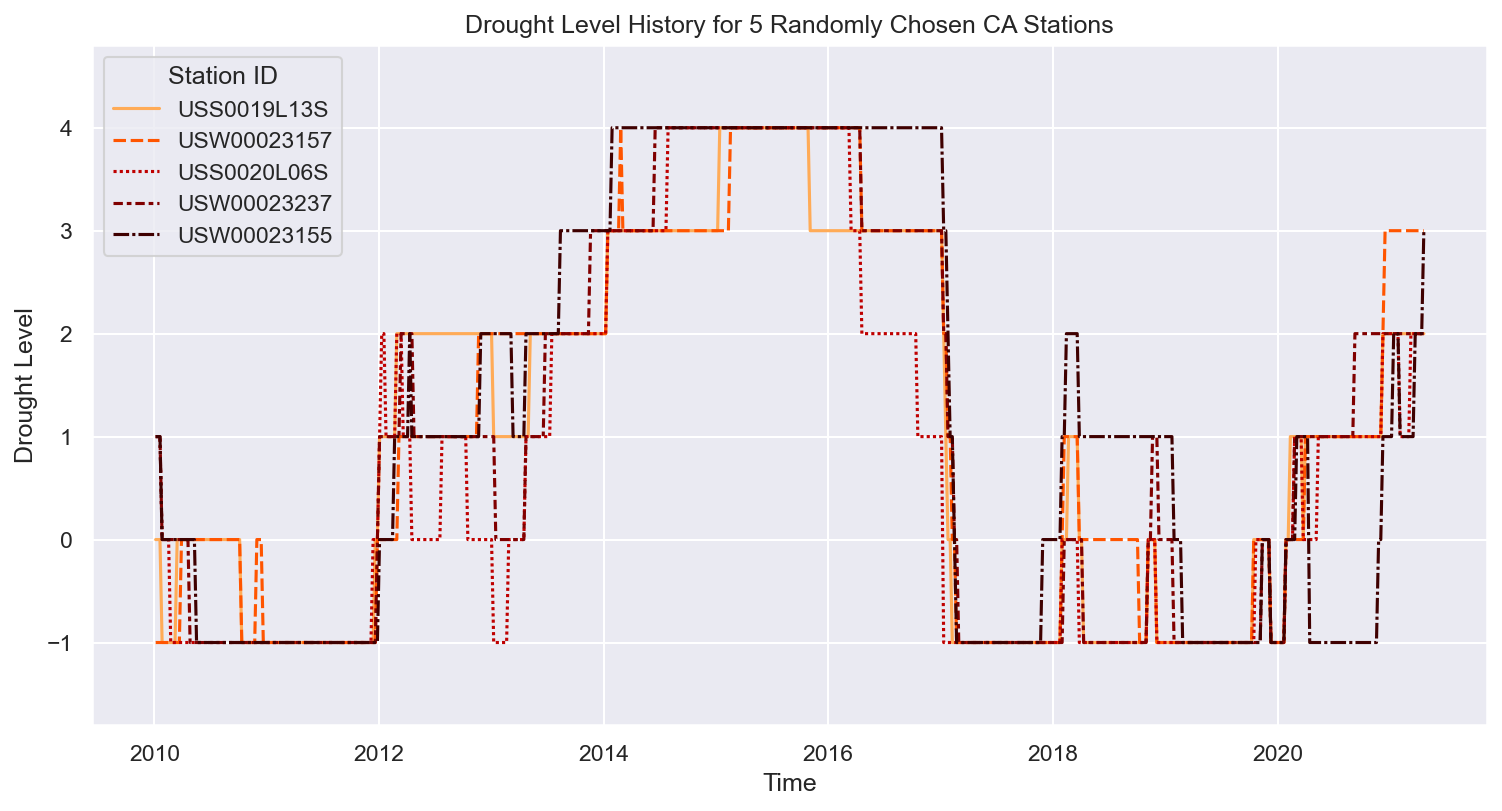

In [10]:
# randomly choose 5 stations to see their drought levels over time
np.random.seed(36)
random_5_stations = orig_ca_dr_levels[np.random.choice(orig_ca_dr_levels.columns.values, 5)]

plt.figure(figsize=[12,6], dpi=150)
g = sns.lineplot(data = random_5_stations, 
                 palette=sns.color_palette("gist_heat_r", 5));

g.get_legend().set_title('Station ID')
plt.xlabel('Time')
plt.ylabel('Drought Level')
plt.ylim([-1.8, 4.8])
plt.title('Drought Level History for 5 Randomly Chosen CA Stations');
# plt.savefig("fig1.png")

In [11]:
SF_COORDINATES = (37.87, -122.28)
    
ca_map_5 = folium.Map(location=SF_COORDINATES, zoom_start=6)

# WITHOUT CLUSTERS
for _, r in ca_stations_2020[ca_stations_2020['Station'].isin(random_5_stations.columns.values)][['Latitude', 'Longitude', 'Station']].dropna().iterrows():
    folium.Marker([float(r["Latitude"]), float(r["Longitude"])], popup=r['Station']).add_to(ca_map_5)

# ca_map.save('ca_map.html')
display(ca_map_5)

### Dataset 4: Historical Weather Data for 48 Selected CA Stations ###

According to the above drought level graph for 5 randomly chosen stations, It seems CA experienced exceptional drought (D4) during 2014 ~ 2017. To get more data points for each of the different 5 levels (**D0, D1, D2, D3, D4**), import the historical data for the selected stations. Specifically, the weather records during **2010-01-05 ~ 2021-01-04** are used. 

Find the descriptions: https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt

In [12]:
# Get the list of 48 station IDs
ca_station_list = list(ca_dr_levels.columns.values)

In [13]:
orig_ca_weather_all = pd.DataFrame()

for station in ca_station_list:
    filename = 'data/CA_historical/'+station+'.csv.gz' 
    
    df_temp = pd.read_csv(filename, 
                          names=["ID", "DATE", "ELEMENT", "VALUE", "FLAG1", "FLAG2", "FLAG3", "FLAG4"], 
                          low_memory=False)
    df_temp['DATE'] = pd.to_datetime(df_temp['DATE'], format='%Y%m%d')
    df_temp = df_temp[(df_temp['DATE'] >= pd.Timestamp(2010, 1, 5)) 
                      & (df_temp['DATE'] <= pd.Timestamp(2021, 1, 4))]
#     df_temp = df_temp[df_temp['ELEMENT'].isin(['TMAX', 'TMIN', 'PRCP', 'TAVG', 'TOBS'])]
    df_temp = df_temp[df_temp['ELEMENT'].isin(['TMAX', 'TMIN', 'PRCP', 'SNWD', 
                                               'TAVG', 'WESD', ])] #'TOBS', 
    
    orig_ca_weather_all = orig_ca_weather_all.append(df_temp, ignore_index=True)

In [14]:
# orig_ca_weather_all['ELEMENT'].unique()
orig_ca_weather_all

,ID,DATE,ELEMENT,VALUE,FLAG1,FLAG2,FLAG3,FLAG4
0,USS0019L03S,2010-01-05,TMAX,96,NaN,NaN,T,NaN
1,USS0019L03S,2010-01-06,TMAX,127,NaN,NaN,T,NaN
2,USS0019L03S,2010-01-07,TMAX,90,NaN,NaN,T,NaN
3,USS0019L03S,2010-01-08,TMAX,116,NaN,NaN,T,NaN
4,USS0019L03S,2010-01-09,TMAX,98,NaN,NaN,T,NaN
...,...,...,...,...,...,...,...,...
1028262,USW00093228,2021-01-04,PRCP,104,NaN,NaN,W,2400.0
1028263,USW00093228,2021-01-01,TAVG,101,H,NaN,S,NaN
1028264,USW00093228,2021-01-02,TAVG,115,H,NaN,S,NaN
1028265,USW00093228,2021-01-03,TAVG,113,H,NaN,S,NaN


In [15]:
# ca_weather_all[ca_weather_all['WDF2'].notnull()]['WDF2']

In [16]:
ca_weather_all = orig_ca_weather_all.pivot_table(index=["ID", "DATE"], columns=["ELEMENT"],values="VALUE")
ca_weather_all = ca_weather_all.reset_index()
ca_weather_all

ELEMENT,ID,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,WESD
0,USS0019L03S,2010-01-05,0.0,508.0,-7.0,96.0,-60.0,1143.0
1,USS0019L03S,2010-01-06,25.0,508.0,8.0,127.0,-55.0,1168.0
2,USS0019L03S,2010-01-07,0.0,483.0,14.0,90.0,-38.0,1168.0
3,USS0019L03S,2010-01-08,0.0,457.0,24.0,116.0,-36.0,1168.0
4,USS0019L03S,2010-01-09,0.0,432.0,27.0,98.0,-15.0,1168.0
...,...,...,...,...,...,...,...,...
191227,USW00093228,2020-12-31,15.0,NaN,116.0,161.0,78.0,NaN
191228,USW00093228,2021-01-01,0.0,NaN,101.0,167.0,50.0,NaN
191229,USW00093228,2021-01-02,18.0,NaN,115.0,139.0,106.0,NaN
191230,USW00093228,2021-01-03,0.0,NaN,113.0,139.0,94.0,NaN


## Data Cleaning

### Check Missing or Abnormal Values

In [17]:
# Check the drought level dataset

if ca_dr_levels.isnull().sum().sum() == 0:
    print ('The drought level dataset doesn\'t have missing values.')
else:
    print('The drought level dataset has missing values.')

The drought level dataset doesn't have missing values.


In [18]:
ca_weather_all.describe()

ELEMENT,PRCP,SNWD,TAVG,TMAX,TMIN,WESD
count,191207.000000,152139.000000,171910.000000,191051.000000,191040.000000,130920.000000
mean,21.312478,390.066774,88.265790,158.534601,38.816562,1677.799404
std,75.946862,744.946827,84.448716,94.713535,80.515418,3234.564092
min,0.000000,0.000000,-204.000000,-125.000000,-314.000000,0.000000
25%,0.000000,0.000000,22.000000,89.000000,-17.000000,0.000000
50%,0.000000,0.000000,90.000000,162.000000,39.000000,0.000000
75%,0.000000,483.000000,151.000000,222.000000,100.000000,1981.000000
max,2235.000000,7112.000000,369.000000,467.000000,306.000000,31013.000000


In [19]:
# Check the historical weather dataset

ca_weather_all.fillna(-999999, inplace=True)
# ca_weather_all.dropna(axis=0, inplace=True)
ca_weather_all.isnull().sum()

ELEMENT
ID      0
DATE    0
PRCP    0
SNWD    0
TAVG    0
TMAX    0
TMIN    0
WESD    0
dtype: int64

In [20]:
ca_weather_all = ca_weather_all.reset_index(drop=True)
ca_weather_all = ca_weather_all.rename_axis("RECORDS", axis="columns")
ca_weather_all

RECORDS,ID,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,WESD
0,USS0019L03S,2010-01-05,0.0,508.0,-7.0,96.0,-60.0,1143.0
1,USS0019L03S,2010-01-06,25.0,508.0,8.0,127.0,-55.0,1168.0
2,USS0019L03S,2010-01-07,0.0,483.0,14.0,90.0,-38.0,1168.0
3,USS0019L03S,2010-01-08,0.0,457.0,24.0,116.0,-36.0,1168.0
4,USS0019L03S,2010-01-09,0.0,432.0,27.0,98.0,-15.0,1168.0
...,...,...,...,...,...,...,...,...
191227,USW00093228,2020-12-31,15.0,-999999.0,116.0,161.0,78.0,-999999.0
191228,USW00093228,2021-01-01,0.0,-999999.0,101.0,167.0,50.0,-999999.0
191229,USW00093228,2021-01-02,18.0,-999999.0,115.0,139.0,106.0,-999999.0
191230,USW00093228,2021-01-03,0.0,-999999.0,113.0,139.0,94.0,-999999.0


In [24]:
# ca_weather_all[ca_weather_all['TOBS'].isnull()]['ID'].value_counts()
ca_weather_all['ID'].value_counts()

USW00023233    4018
USS0019L39S    4018
USS0019L03S    4018
USW00023129    4018
USS0019L08S    4018
USS0019L40S    4018
USS0019L42S    4018
USS0019L17S    4018
USS0019L38S    4018
USS0020K25S    4018
USS0019L06S    4018
USS0020K27S    4018
USS0019L41S    4018
USS0020K04S    4018
USW00023234    4018
USS0019L45S    4018
USS0020L10S    4018
USW00023273    4018
USS0020L06S    4018
USW00024257    4018
USS0020K03S    4018
USS0019L43S    4018
USS0019L24S    4018
USW00023237    4018
USS0020L02S    4018
USS0019L13S    4018
USS0019L07S    4018
USS0020H12S    4018
USS0020K30S    4018
USW00023232    4018
USS0020K31S    4018
USW00023174    4018
USS0019L44S    4018
USW00023155    4018
USW00024213    4018
USW00023157    4018
USS0019L19S    4018
USS0020H13S    4018
USS0020H06S    4018
USS0020K13S    4018
USW00024216    4018
USW00023254    4018
USS0019L05S    4018
USW00023188    4018
USW00093193    4018
USS0020H02S    4017
USW00093228    4013
USS0020H01S    2392
Name: ID, dtype: int64

In [25]:
ca_stations_updated = ca_stations_2020[ca_stations_2020['Station'].isin(ca_weather_all['ID'].unique())]
ca_stations_updated

,Station,Latitude,Longitude,Elevation,STATE,NAME,GSNFLAG,HCNFLAG,WMOID
0,USS0019L03S,38.8500,-119.9400,2370.1,CA,Hagan's Meadow,,,
1,USS0019L05S,38.6100,-119.9200,2455.8,CA,Blue Lakes,,,
2,USS0019L06S,38.5100,-119.6300,2357.9,CA,Poison Flat,,,
3,USS0019L07S,38.3100,-119.6000,2690.5,CA,Sonora Pass,,,
4,USS0019L08S,38.3000,-119.5500,2194.0,CA,Leavitt Meadows,,,
5,USS0019L13S,38.0700,-119.2300,2878.8,CA,Virginia Lakes Ridge,,,
6,USS0019L17S,38.4400,-119.3700,2814.2,CA,Lobdell Lake,,,
7,USS0019L19S,38.5500,-119.8000,2671.6,CA,Ebbetts Pass,,,
8,USS0019L24S,38.9200,-119.9200,2615.8,CA,Heavenly Valley,,,
9,USS0019L38S,38.2800,-119.6100,2931.3,CA,Leavitt Lake,,,


In [26]:
# Plot the locations of the updated CA stations on a map: 

SF_COORDINATES = (37.87, -122.28)

cluster = folium.plugins.MarkerCluster()
for _, r in ca_stations_updated[['Latitude', 'Longitude', 'Station']].dropna().iterrows():
    cluster.add_child(
        folium.Marker([float(r["Latitude"]), float(r["Longitude"])], popup=r['Station']))
    
ca_map = folium.Map(location=SF_COORDINATES, zoom_start=6)
ca_map.add_child(cluster)

# WITHOUT CLUSTERS
# for _, r in ca_stations_2020[['Latitude', 'Longitude', 'Station']].dropna().iterrows():
#     folium.Marker([float(r["Latitude"]), float(r["Longitude"])], popup=r['Station']).add_to(ca_map)

# ca_map.save('ca_map.html')
display(ca_map)

### Transform the Data According to the Documentation

* PRCP = Precipitation (tenths of mm)
* TMAX = Maximum temperature (tenths of degrees C)
* TMIN = Minimum temperature (tenths of degrees C)
* TAVG = Average temperature (tenths of degrees C) (Note that TAVG from source 'S' corresponds to an average for the period ending at 2400 UTC rather than local midnight)
* TOBS = Temperature at the time of observation (tenths of degrees C)
* SNWD = Snow depth (mm)
* WESD = Water equivalent of snow on the ground (tenths of mm)

In [27]:
# Assign different units

ca_weather_all['PRCP (mm)'] = ca_weather_all['PRCP'] / 10.0
ca_weather_all['TAVG (deg C)'] = ca_weather_all['TAVG'] / 10.0
ca_weather_all['TMAX (deg C)'] = ca_weather_all['TMAX'] / 10.0
ca_weather_all['TMIN (deg C)'] = ca_weather_all['TMIN'] / 10.0
# ca_weather_all['TOBS (deg C)'] = ca_weather_all['TOBS'] / 10.0
ca_weather_all['SNWD (mm)'] = ca_weather_all['SNWD']
ca_weather_all['WESD (mm)'] = ca_weather_all['WESD'] / 10.0

In [28]:
ca_weather_all.tail()

RECORDS,ID,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,WESD,PRCP (mm),TAVG (deg C),TMAX (deg C),TMIN (deg C),SNWD (mm),WESD (mm)
191227,USW00093228,2020-12-31,15.0,-999999.0,116.0,161.0,78.0,-999999.0,1.5,11.6,16.1,7.8,-999999.0,-99999.9
191228,USW00093228,2021-01-01,0.0,-999999.0,101.0,167.0,50.0,-999999.0,0.0,10.1,16.7,5.0,-999999.0,-99999.9
191229,USW00093228,2021-01-02,18.0,-999999.0,115.0,139.0,106.0,-999999.0,1.8,11.5,13.9,10.6,-999999.0,-99999.9
191230,USW00093228,2021-01-03,0.0,-999999.0,113.0,139.0,94.0,-999999.0,0.0,11.3,13.9,9.4,-999999.0,-99999.9
191231,USW00093228,2021-01-04,104.0,-999999.0,130.0,167.0,78.0,-999999.0,10.4,13.0,16.7,7.8,-999999.0,-99999.9


In [29]:
# Rename the labels and count their frequencies

ca_dr_levels = ca_dr_levels.loc['2010-01-01':'2020-12-31', :]
ca_dr_levels = ca_dr_levels.replace({-1: 'Wet', 0: 'D0', 1: 'D1', 2: 'D2', 3: 'D3', 4: 'D4'})
ca_dr_levels.apply(pd.value_counts)

Station,USS0019L03S,USS0019L05S,USS0019L06S,USS0019L07S,USS0019L08S,USS0019L13S,USS0019L17S,USS0019L19S,USS0019L24S,USS0019L38S,...,USW00023233,USW00023234,USW00023237,USW00023254,USW00023273,USW00024213,USW00024216,USW00024257,USW00093193,USW00093228
D0,68,78,61,57,63,57,58,74,94,57,...,63,96,56,77,57,80,94,116,71,59
D1,92,77,80,88,86,73,70,86,88,87,...,65,64,94,65,81,78,91,74,104,103
D2,66,64,95,53,48,86,102,61,70,51,...,79,74,46,107,68,37,65,63,57,71
D3,37,45,61,95,98,114,101,45,37,98,...,67,64,68,79,29,60,112,94,54,71
D4,85,85,61,66,66,42,40,85,85,66,...,46,42,96,34,151,20,20,20,112,42
Wet,226,225,216,215,213,202,203,223,200,215,...,254,234,214,212,188,299,192,207,176,228


### Assign the Drought Level to the Corresponding Record ###

According to US Drought Monitor documentation, the valid period of each drought category is the week starting from its release date (Tuesdays). 

* Group the weather records by the station, week number
* Assign the labels to each record
* Also assign the statitics (lat, lon, height) of the stations 

In [30]:
# First (convert column date to_datetime and) substract 6 days, 
# as we want to statistics for the week ahead of the date, not the week before that date.

ca_weather_all['Start_Date'] = ca_weather_all['DATE'] - pd.to_timedelta(6, unit='d')
ca_weather_weekly = ca_weather_all.groupby(['ID', 
                                            pd.Grouper(key='Start_Date', freq='W-TUE')
                                           ]
                                          ).agg({'PRCP (mm)': 'mean',
                                                 'TAVG (deg C)': 'mean',
                                                 'TMAX (deg C)': 'max',
                                                 'TMIN (deg C)': 'min',
#                                                  'TOBS (deg C)': 'mean',
                                                 'SNWD (mm)': 'mean',
                                                 'WESD (mm)': 'mean', }
                                               ).reset_index()


# ca_weather_all[['DATE']].groupby(pd.Grouper(key='DATE', freq='W-TUE')).first()
# ca_weather_all[['Start_Date', 'DATE']].groupby(pd.Grouper(key='Start_Date', freq='W-TUE')).last()
ca_weather_weekly

,ID,Start_Date,PRCP (mm),TAVG (deg C),TMAX (deg C),TMIN (deg C),SNWD (mm),WESD (mm)
0,USS0019L03S,2010-01-05,0.714286,1.614286,12.7,-6.0,464.571429,116.814286
1,USS0019L03S,2010-01-12,9.785714,-0.828571,8.2,-11.6,671.428571,149.157143
2,USS0019L03S,2010-01-19,8.700000,-4.257143,4.0,-14.3,1222.714286,232.942857
3,USS0019L03S,2010-01-26,0.357143,-2.185714,8.2,-14.1,1143.000000,257.614286
4,USS0019L03S,2010-02-02,3.628571,-1.057143,6.3,-9.5,1095.714286,275.057143
...,...,...,...,...,...,...,...,...
27315,USW00093228,2020-12-01,0.000000,11.657143,24.4,5.0,-999999.000000,-99999.900000
27316,USW00093228,2020-12-08,3.257143,12.571429,22.2,5.6,-999999.000000,-99999.900000
27317,USW00093228,2020-12-15,2.100000,10.528571,17.2,3.9,-999999.000000,-99999.900000
27318,USW00093228,2020-12-22,0.571429,11.585714,18.3,4.4,-999999.000000,-99999.900000


In [31]:
# Check if the groupby method works correctly. Randomly choose a row, e.g., the top 3rd line

ca_weather_all[(ca_weather_all['ID'] == 'USS0019L03S') & 
               (ca_weather_all['DATE'] >= pd.Timestamp(2010, 1, 19)) & 
               (ca_weather_all['DATE'] <= pd.Timestamp(2010, 1, 25))].apply({'PRCP (mm)': 'mean', 
                                                                             'TAVG (deg C)': 'mean', 
                                                                             'TMAX (deg C)': 'max', 
                                                                             'TMIN (deg C)': 'min',
#                                                                              'TOBS (deg C)': 'mean',
                                                                             'SNWD (mm)': 'mean',
                                                                             'WESD (mm)': 'mean',})


PRCP (mm)       8.700000   
TAVG (deg C)   -4.257143   
TMAX (deg C)    4.000000   
TMIN (deg C)   -14.300000  
SNWD (mm)       1222.714286
WESD (mm)       232.942857 
dtype: float64

In [32]:
# Use pd.melt to reshape the drought level dataframes

ca_dr_levels_long = pd.melt(ca_dr_levels.reset_index(), 
                            id_vars=['DateTime'], 
                            var_name='Station', 
                            value_name='Drought Level')
ca_dr_levels_long.head()

,DateTime,Station,Drought Level
0,2010-01-05,USS0019L03S,D1
1,2010-01-12,USS0019L03S,D1
2,2010-01-19,USS0019L03S,D1
3,2010-01-26,USS0019L03S,D1
4,2010-02-02,USS0019L03S,D1


In [33]:
# Combine all information

df_final = pd.merge(ca_weather_weekly, ca_dr_levels_long, 
                    how = 'left', 
                    left_on = ['ID', 'Start_Date'], 
                    right_on = ['Station', 'DateTime']
                   ).drop(columns = ['Station', 'DateTime'])
df_final = df_final.merge(ca_stations_2020[['Station', 'Latitude', 'Longitude', 'Elevation']], 
                          how = 'left', left_on = 'ID', right_on = 'Station'
                         ).drop(columns = ['Station'])
df_final

,ID,Start_Date,PRCP (mm),TAVG (deg C),TMAX (deg C),TMIN (deg C),SNWD (mm),WESD (mm),Drought Level,Latitude,Longitude,Elevation
0,USS0019L03S,2010-01-05,0.714286,1.614286,12.7,-6.0,464.571429,116.814286,D1,38.8500,-119.940,2370.1
1,USS0019L03S,2010-01-12,9.785714,-0.828571,8.2,-11.6,671.428571,149.157143,D1,38.8500,-119.940,2370.1
2,USS0019L03S,2010-01-19,8.700000,-4.257143,4.0,-14.3,1222.714286,232.942857,D1,38.8500,-119.940,2370.1
3,USS0019L03S,2010-01-26,0.357143,-2.185714,8.2,-14.1,1143.000000,257.614286,D1,38.8500,-119.940,2370.1
4,USS0019L03S,2010-02-02,3.628571,-1.057143,6.3,-9.5,1095.714286,275.057143,D1,38.8500,-119.940,2370.1
...,...,...,...,...,...,...,...,...,...,...,...,...
27315,USW00093228,2020-12-01,0.000000,11.657143,24.4,5.0,-999999.000000,-99999.900000,D2,37.6542,-122.115,13.1
27316,USW00093228,2020-12-08,3.257143,12.571429,22.2,5.6,-999999.000000,-99999.900000,D2,37.6542,-122.115,13.1
27317,USW00093228,2020-12-15,2.100000,10.528571,17.2,3.9,-999999.000000,-99999.900000,D2,37.6542,-122.115,13.1
27318,USW00093228,2020-12-22,0.571429,11.585714,18.3,4.4,-999999.000000,-99999.900000,D2,37.6542,-122.115,13.1


## Exploratory Data Analysis

In [34]:
df_plot = df_final.copy()
df_plot['Year'] = df_plot['Start_Date'].dt.year
df_plot['Month'] = df_plot['Start_Date'].dt.month
df_plot['Week'] = df_plot['Start_Date'].dt.week
df_plot['Day'] = df_plot['Start_Date'].dt.day
df_plot.head()

,ID,Start_Date,PRCP (mm),TAVG (deg C),TMAX (deg C),TMIN (deg C),SNWD (mm),WESD (mm),Drought Level,Latitude,Longitude,Elevation,Year,Month,Week,Day
0,USS0019L03S,2010-01-05,0.714286,1.614286,12.7,-6.0,464.571429,116.814286,D1,38.85,-119.94,2370.1,2010,1,1,5
1,USS0019L03S,2010-01-12,9.785714,-0.828571,8.2,-11.6,671.428571,149.157143,D1,38.85,-119.94,2370.1,2010,1,2,12
2,USS0019L03S,2010-01-19,8.700000,-4.257143,4.0,-14.3,1222.714286,232.942857,D1,38.85,-119.94,2370.1,2010,1,3,19
3,USS0019L03S,2010-01-26,0.357143,-2.185714,8.2,-14.1,1143.000000,257.614286,D1,38.85,-119.94,2370.1,2010,1,4,26
4,USS0019L03S,2010-02-02,3.628571,-1.057143,6.3,-9.5,1095.714286,275.057143,D1,38.85,-119.94,2370.1,2010,2,5,2


### Drought Level v.s. Time ###

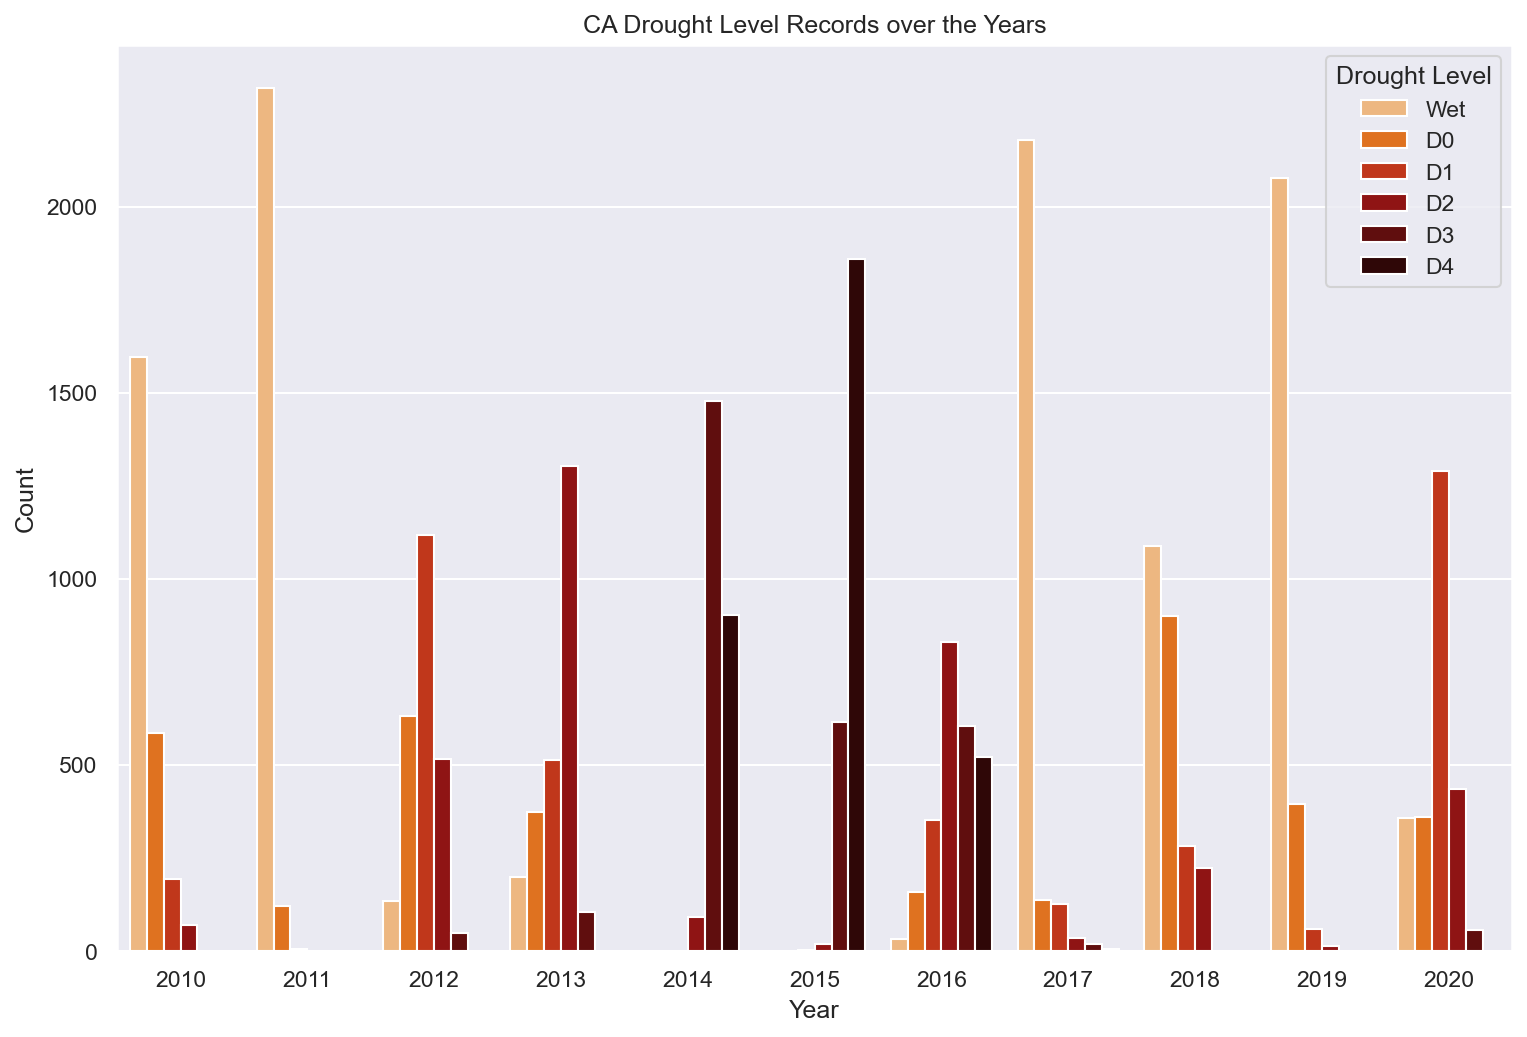

In [35]:
df_plot_1 = df_plot.sort_values(by='Drought Level')
df_plot_1 = df_plot_1[['Year', 'Drought Level', 'Start_Date']].groupby(['Year', 'Drought Level']).agg('count')
df_plot_1.rename(columns={'Start_Date': 'Count'}, inplace=True)
df_plot_1 = df_plot_1.reset_index()

plt.figure(figsize=[12,8], dpi=150)
sns.barplot(data = df_plot_1,
            x='Year', y='Count', hue='Drought Level',
            hue_order=['Wet', 'D0', 'D1', 'D2', 'D3', 'D4'],
            palette=sns.color_palette("gist_heat_r", 6),
            );
plt.title('CA Drought Level Records over the Years');
# plt.savefig("fig2.png")

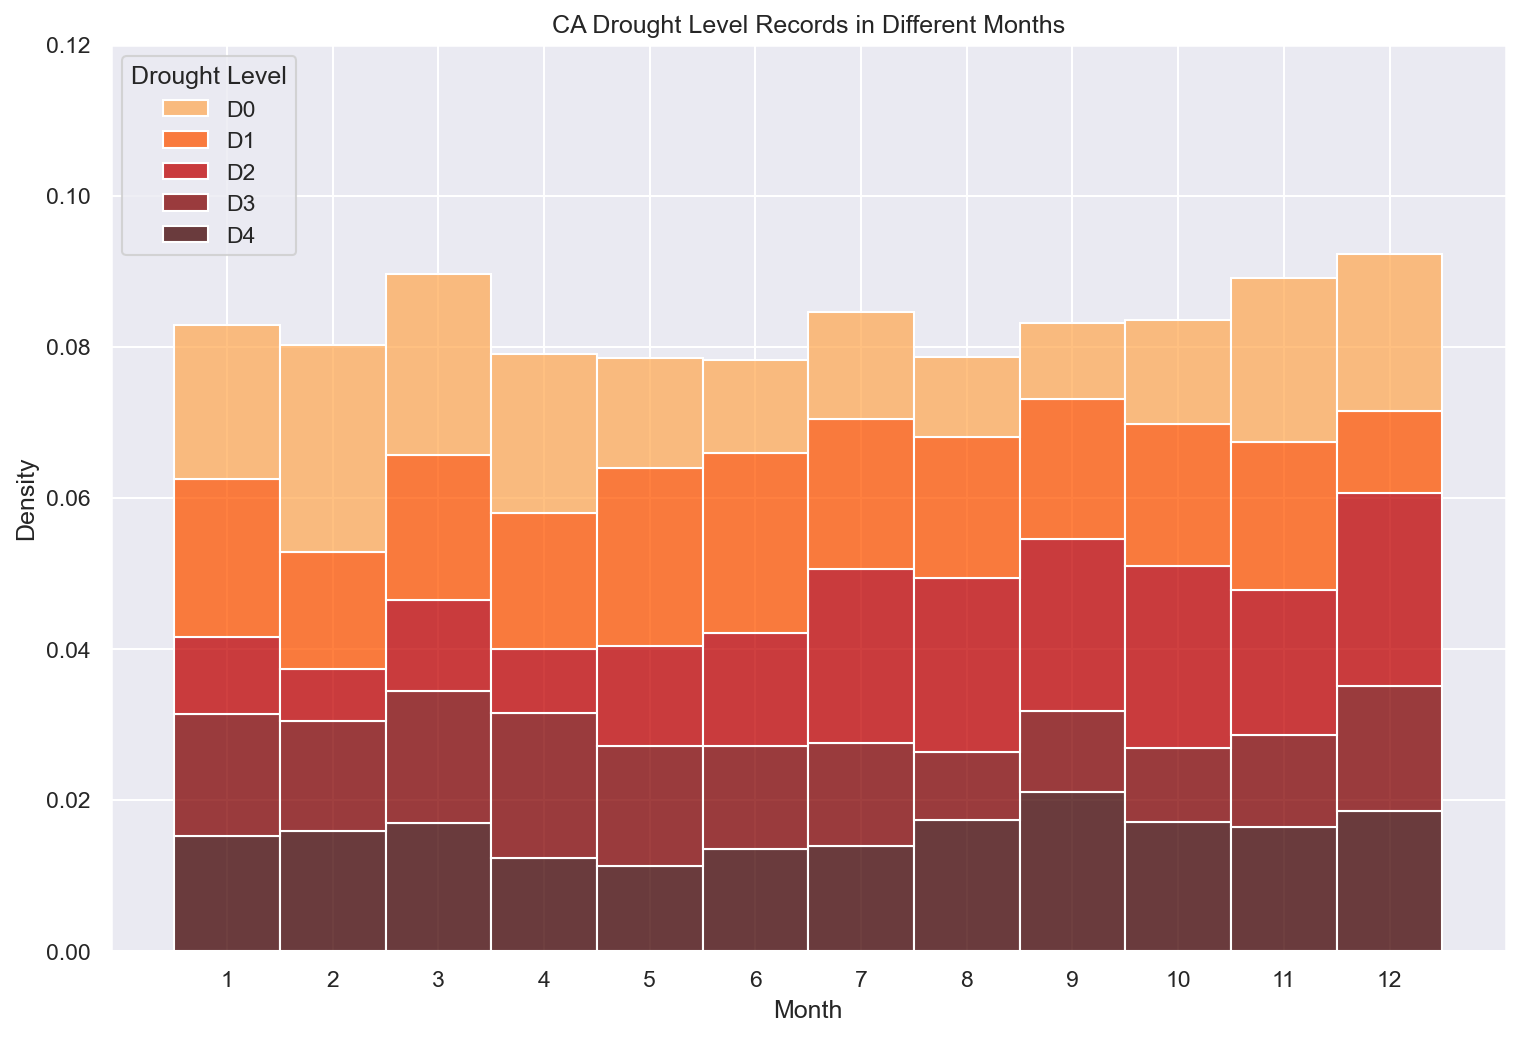

In [36]:
df_plot_dr = df_plot[df_plot['Drought Level'] != 'Wet']

plt.figure(figsize=[12,8], dpi=150)
sns.histplot(df_plot_dr, x='Month', hue='Drought Level', 
#              hue_order=['D4', 'D3', 'D2', 'D1', 'D0'],
             hue_order=['D0', 'D1', 'D2', 'D3', 'D4'],
             palette=sns.color_palette("gist_heat_r", 5),
             stat="density", common_norm=True,
             bins=np.arange(0.5, 13.5),
             # kde=True,
             multiple = 'stack',
             # element="step"
             ); 
plt.title('CA Drought Level Records in Different Months');
plt.xticks(np.arange(1, 13), np.arange(1, 13));
plt.ylim([0, 0.12]);
# plt.savefig("fig3.png")

### Drought Level v.s. Temperature ###

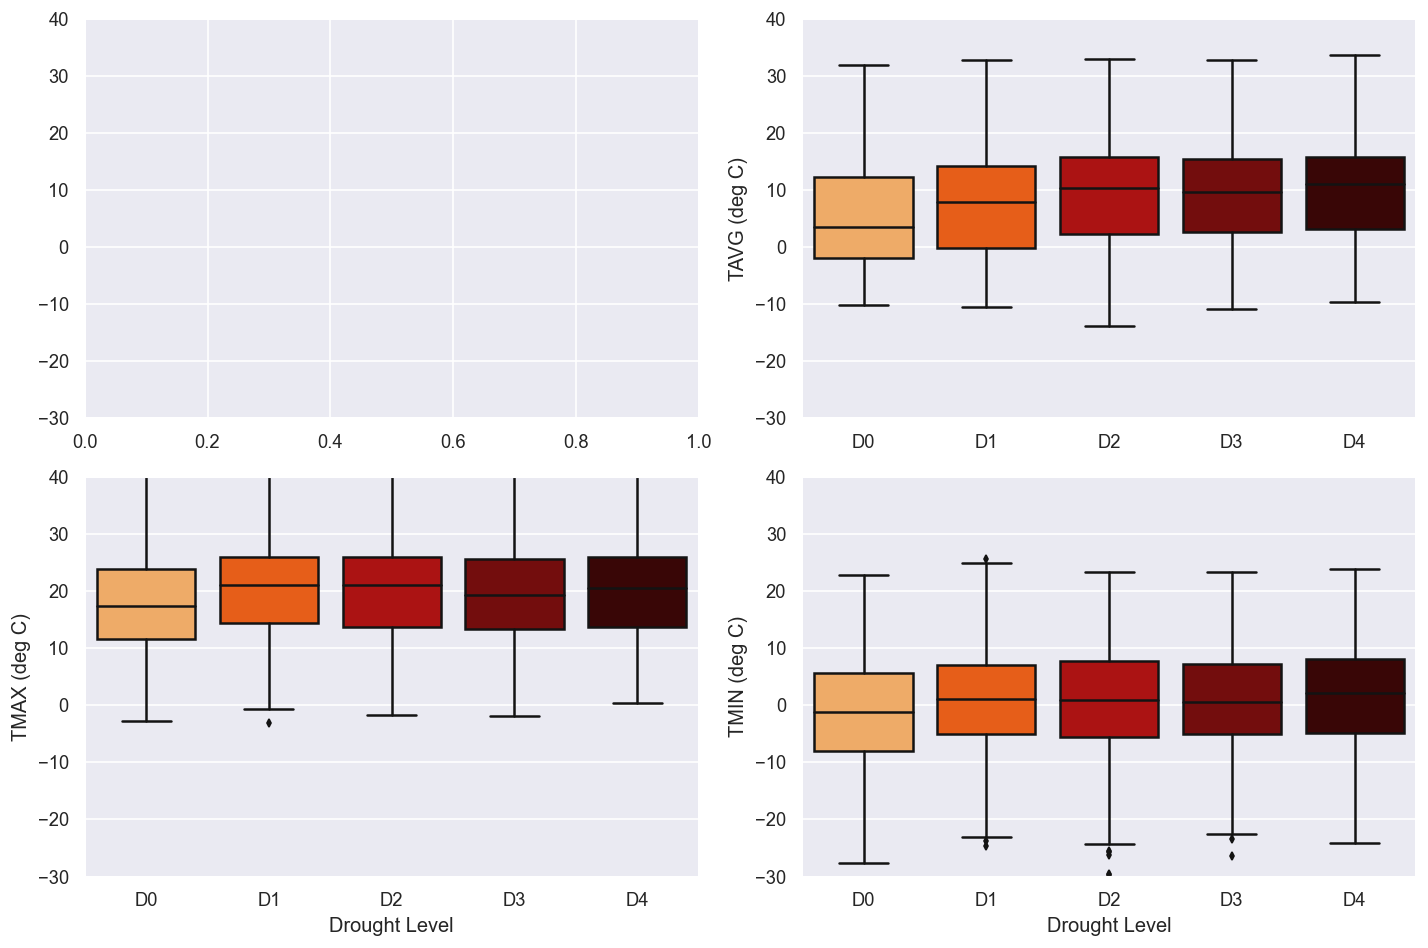

In [37]:
fig, axes = plt.subplots(2, 2, figsize=[12,8], dpi=120)

# sns.boxplot(data=df_plot_dr.sort_values(by='Drought Level'), 
#             y='TOBS (deg C)', x='Drought Level', palette=sns.color_palette("gist_heat_r", 5),
#             saturation=0.8, width=0.8, dodge=True, fliersize=3,
#             orient='v', ax=axes[0, 0]);

sns.boxplot(data=df_plot_dr.sort_values(by='Drought Level'), 
            y='TAVG (deg C)', x='Drought Level', palette=sns.color_palette("gist_heat_r", 5),
            saturation=0.8, width=0.8, dodge=True, fliersize=3,
            orient='v', ax=axes[0, 1]);

sns.boxplot(data=df_plot_dr.sort_values(by='Drought Level'), 
            y='TMAX (deg C)', x='Drought Level', palette=sns.color_palette("gist_heat_r", 5),
            saturation=0.8, width=0.8, dodge=True, fliersize=3,
#             whis=[1, 99], 
            orient='v', ax=axes[1, 0]);

sns.boxplot(data=df_plot_dr.sort_values(by='Drought Level'), 
            y='TMIN (deg C)', x='Drought Level', palette=sns.color_palette("gist_heat_r", 5),
            saturation=0.8, width=0.8, dodge=True, fliersize=3,
            orient='v', ax=axes[1, 1]);


axes[0, 0].set_xlabel('');
axes[0, 1].set_xlabel('');
plt.setp(axes, ylim=[-30, 40]);

plt.tight_layout();
# plt.savefig("fig4.png")

### Drought Level v.s. Precipitation ###

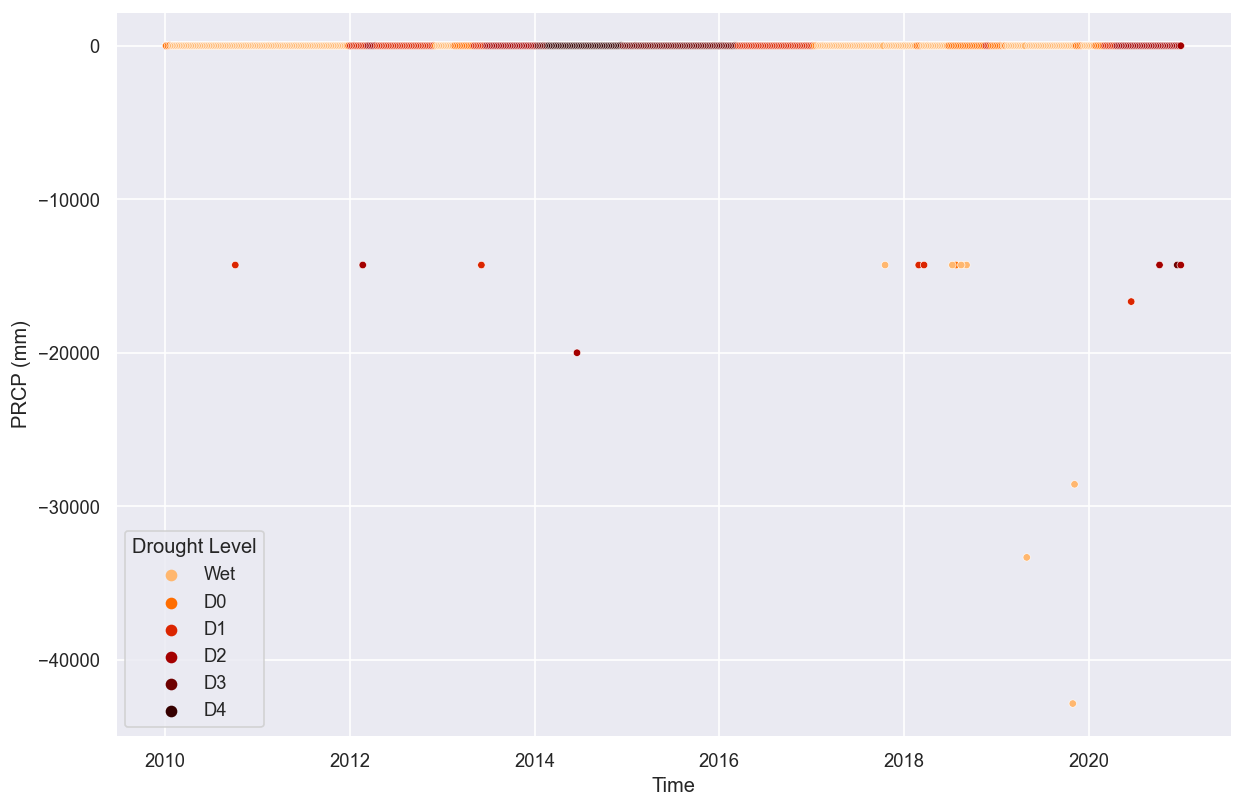

In [38]:
plt.figure(figsize=[12,8], dpi=120)

sns.scatterplot(data=df_plot, #.sample(n=100, random_state=20), 
                y='PRCP (mm)', x='Start_Date',
                hue='Drought Level', hue_order=['Wet', 'D0', 'D1', 'D2', 'D3', 'D4'],
                palette=sns.color_palette("gist_heat_r", 6),
                x_jitter=True,
                s=20
                );
plt.xlabel('Time');
# plt.savefig("fig5.png")

### Statistics for One Chosen Station ###

Choose a station which locates near **Berkeley**: 

In [39]:
import geopy

def get_address(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df.loc[:, lat_field].values, 
                                   df.loc[:, lon_field].values))
    return location.raw['address']

geolocator = geopy.Nominatim(user_agent="http")

pprint(get_address(ca_stations_2020[ca_stations_2020['Station'] == 'USW00023254'], 
            geolocator, 'Latitude', 'Longitude')) # DAVIS: 'USW00023232'

{'aeroway': 'Buchanan Field Airport',
 'city': 'Concord',
 'country': 'United States',
 'country_code': 'us',
 'county': 'Contra Costa County',
 'postcode': '1355',
 'road': 'Iron Horse Trail',
 'state': 'California'}


In [40]:
orig_ca_dr_levels.loc['2010-01-01':'2021-01-31', 'USW00023254']

DateTime
2010-01-05    1
2010-01-12    1
2010-01-19    1
2010-01-26    0
2010-02-02    0
             ..
2020-12-29    2
2021-01-05    2
2021-01-12    2
2021-01-19    2
2021-01-26    2
Name: USW00023254, Length: 578, dtype: int64

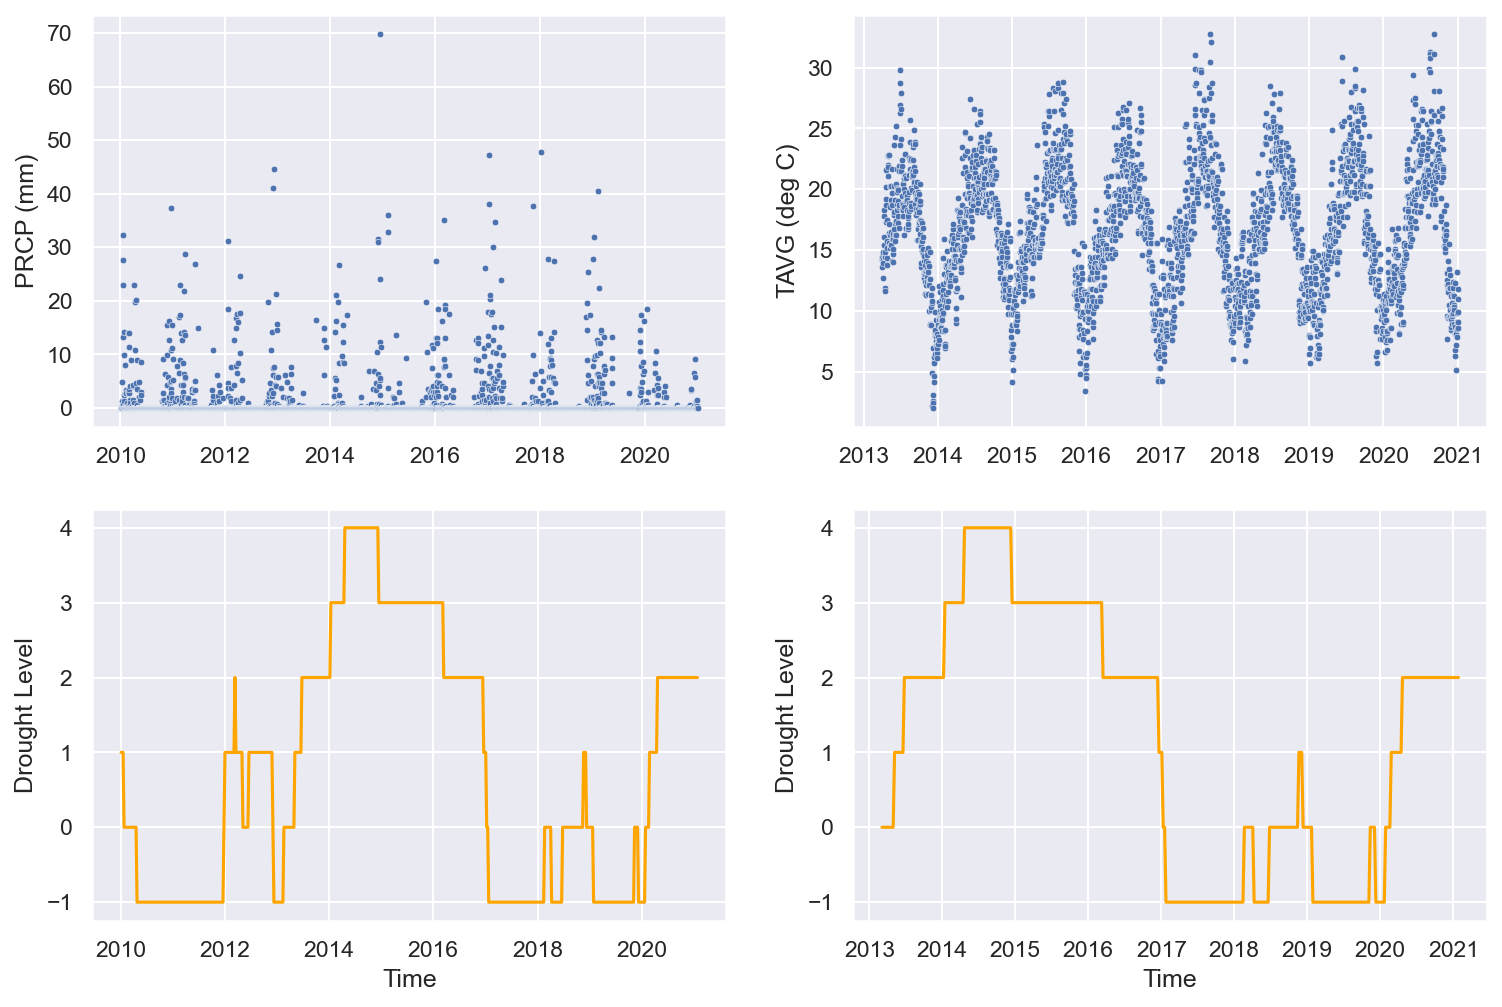

In [41]:
# register_matplotlib_converters()

plot_temp = (orig_ca_weather_all[orig_ca_weather_all['ID'] == 'USW00023254']
                            .pivot_table(index=["ID", "DATE"], 
                                         columns=["ELEMENT"],
                                         values="VALUE")
           )

plot_temp['PRCP (mm)'] = plot_temp['PRCP'] / 10.0
plot_temp['TAVG (deg C)'] = plot_temp['TAVG'] / 10.0
plot_temp['TMAX (deg C)'] = plot_temp['TMAX'] / 10.0
plot_temp['TMIN (deg C)'] = plot_temp['TMIN'] / 10.0
# plot_temp['SNWD (mm)'] = plot_temp['SNWD']
# plot_temp['WESD (mm)'] = plot_temp['WESD'] / 10.0

plot_temp.sort_values('DATE', inplace=True)
plot_temp.reset_index(inplace=True)
plot_temp['DATE'] = pd.to_datetime(plot_temp['DATE'])
plot_temp.drop(columns={'PRCP', 'TAVG', 'TMAX', 'TMIN', 'SNWD'}, inplace=True)


# Plot datapoints from 'USW00023254'
fig, axes = plt.subplots(2, 2, figsize = [12,8], dpi=150)

sns.scatterplot(plot_temp['DATE'], plot_temp['PRCP (mm)'], s=10, ax=axes[0, 0])
axes[0, 0].set_xlabel('')

sns.scatterplot(plot_temp['DATE'], plot_temp['TAVG (deg C)'], s=10, ax=axes[0, 1])
axes[0, 1].set_xlabel('')

sns.lineplot(data = orig_ca_dr_levels.loc['2010-01-01':'2021-01-31', 'USW00023254'],
             color='orange', ax=axes[1, 0])
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Drought Level')

sns.lineplot(data = orig_ca_dr_levels.loc['2013-03-01':'2021-01-31', 'USW00023254'],
             color='orange', ax=axes[1, 1])
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Drought Level');


# fig.suptitle("History Data for Station USW00023254", fontsize="x-large");
# plt.savefig("fig6.png")

In [42]:
plot_temp

ELEMENT,ID,DATE,PRCP (mm),TAVG (deg C),TMAX (deg C),TMIN (deg C)
0,USW00023254,2010-01-05,0.0,NaN,11.7,2.2
1,USW00023254,2010-01-06,0.0,NaN,10.6,4.4
2,USW00023254,2010-01-07,0.0,NaN,9.4,3.9
3,USW00023254,2010-01-08,0.3,NaN,9.4,6.7
4,USW00023254,2010-01-09,0.0,NaN,11.7,4.4
...,...,...,...,...,...,...
4013,USW00023254,2020-12-31,0.3,11.0,16.1,5.6
4014,USW00023254,2021-01-01,0.0,8.6,13.9,2.8
4015,USW00023254,2021-01-02,1.5,9.1,10.6,8.3
4016,USW00023254,2021-01-03,0.0,9.9,13.9,6.7


<Figure size 1800x1200 with 0 Axes>

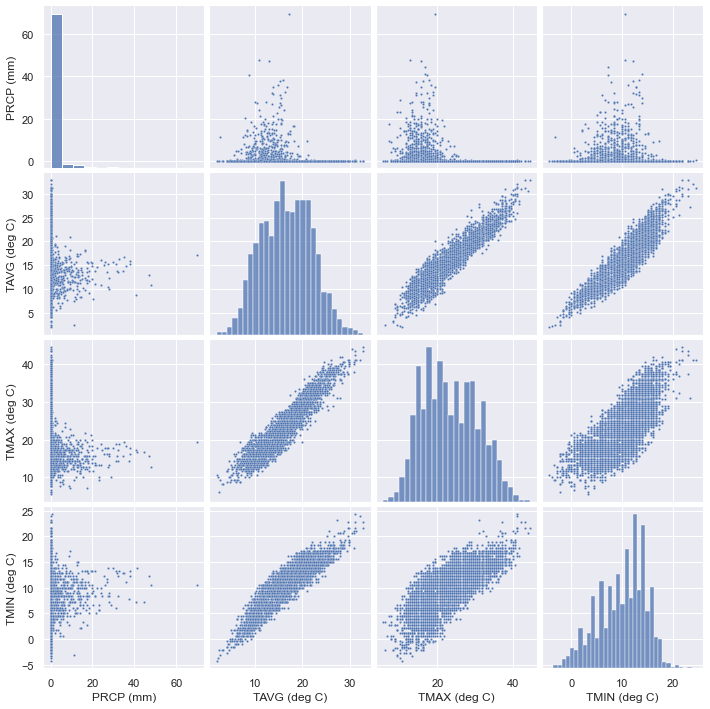

In [43]:
plt.figure(figsize = [12,8], dpi=150);
sns.pairplot(plot_temp, plot_kws={"s": 5});
# plt.savefig("fig7.png")

## Data Modeling and Inferences

In [44]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=[6, 6], dpi=125)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


### Decision Tree - Drought / No Drought (Wet) Classification ###

In [45]:
df_final_dr = df_final[df_final['Drought Level'] != 'Wet']
df_final_wet = df_final[df_final['Drought Level'] == 'Wet']
print('There are', df_final_dr.shape[0], 'records labelled as DROUGHT.')
print('There are', df_final_wet.shape[0], 'records labelled as WET.')

There are 17340 records labelled as DROUGHT.
There are 9980 records labelled as WET.


In [46]:
# Train : Test = 4 : 1

original_training_data, test = train_test_split(df_final, test_size=0.2, random_state=42)
train, val = train_test_split(original_training_data, test_size=0.1, random_state=0)

In [47]:
def process_dr_or_wet(data): 
    '''
    Define the pipeline function
    ''' 
    df = data.copy()
    
    # Add more features
    df['Week'] = df['Start_Date'].dt.week
    df['Month'] = df['Start_Date'].dt.month
    df['Day'] = df['Start_Date'].dt.day
#     df['T_diff'] = df['TMAX (deg C)'] - df['TMIN (deg C)']
    
    df['D_or_W'] = (df['Drought Level'] != 'Wet').astype(int)
    df['D_or_W'] = df['D_or_W'].replace({0: 'No Drought', 1: 'Drought'})

    # Return predictors and response variables separately
    y = df.loc[:, 'D_or_W']
    
    X = df.drop(columns=["ID", "Start_Date", "Drought Level", 'D_or_W', 
                         ]) # 'TOBS (deg C)', 'TMAX (deg C)', 'TMIN (deg C)'
    scaler = StandardScaler().fit(X)
#     X = scaler.transform(X)
    
    return X, y
    
X_1_train, y_1_train = process_dr_or_wet(train)
X_1_val, y_1_val = process_dr_or_wet(val)
X_1_test, y_1_test = process_dr_or_wet(test)

In [48]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score
# from sklearn.tree import DecisionTreeClassifier

# param_grid = {'max_depth': np.arange(3, 10)}

# tree = GridSearchCV(DecisionTreeClassifier(), param_grid)

# tree.fit(X_1_train, y_1_train)
# tree_preds = tree.predict_proba(X_1_val)[:, 1]
# tree_performance = roc_auc_score(y_1_val, tree_preds)

# print('DecisionTree: Area under the ROC curve = {}'.format(tree_performance))
# tree.best_params_

In [49]:
decision_tree_model = tree.DecisionTreeClassifier(min_samples_leaf=3, 
                                                  min_samples_split=2,
                                                  max_depth=None,
                                                  random_state = 0)
decision_tree_model = decision_tree_model.fit(X_1_train, y_1_train)
decision_tree_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [50]:
print('Training Accuracy:', accuracy_score(decision_tree_model.predict(X_1_train), y_1_train))
print('Validation Accuracy:', accuracy_score(decision_tree_model.predict(X_1_val), y_1_val))
print('Testing Accuracy:', accuracy_score(decision_tree_model.predict(X_1_test), y_1_test))

Training Accuracy: 0.9428063040162684
Validation Accuracy: 0.7689844464775847
Testing Accuracy: 0.7726939970717424


Confusion matrix, without normalization
[[2878  575]
 [ 667 1344]]
Normalized confusion matrix
[[0.83347813 0.16652187]
 [0.33167578 0.66832422]]


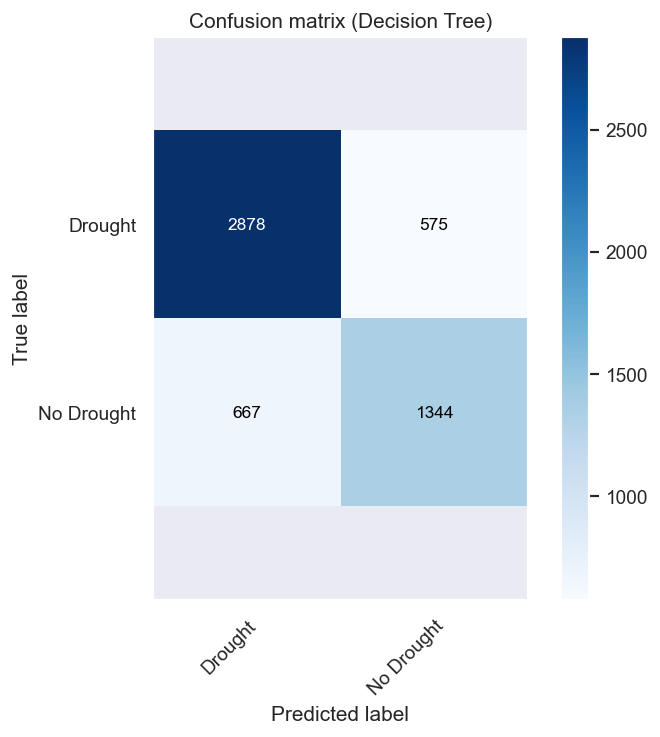

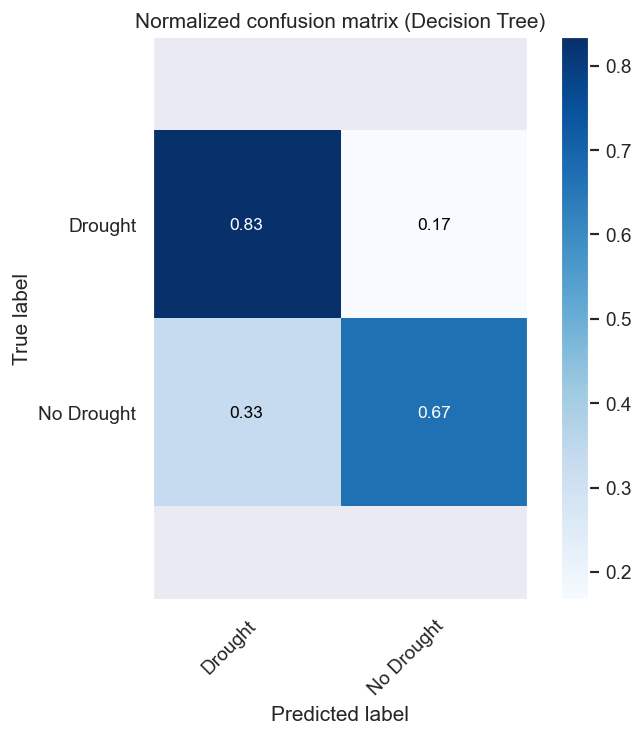

In [51]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_1_test, decision_tree_model.predict(X_1_test),
                      title='Confusion matrix (Decision Tree)')
plt.grid(False)

# plt.savefig("fig8.png")

# Plot normalized confusion matrix
plot_confusion_matrix(y_1_test, decision_tree_model.predict(X_1_test), normalize=True,
                      title='Normalized confusion matrix (Decision Tree)')
plt.grid(False)

# plt.savefig("fig9.png")

plt.show()

In [52]:
# import graphviz
# dot_data = tree.export_graphviz(decision_tree_model, out_file=None,
# #                       feature_names=[],
#                       class_names=["drought", "wet"],
#                       filled=True, rounded=True,
#                       special_characters=True)
# graph = graphviz.Source(dot_data)
# graph

### Random Forest - Drought Level Classification (D0, D1, D2, D3, D4) ###

In [53]:
# Split only the drought Data

train_dr, test_dr = train_test_split(df_final_dr, test_size=0.2, random_state=42)

In [54]:
def get_X_dr_5(data): 
    '''
    Define the pipeline function
    ''' 
    df = data.copy()    
    
    # Add more features
    df['Week'] = df['Start_Date'].dt.week
    df['Month'] = df['Start_Date'].dt.month    
    df['Day'] = df['Start_Date'].dt.day
#     df['T_diff'] = df['TMAX (deg C)'] - df['TMIN (deg C)']
    
    # Return predictors and response variables separately
    X = df.drop(columns=["ID", "Start_Date", "Drought Level", 'SNWD (mm)']) #  'TOBS (deg C)'
    scaler = StandardScaler().fit(X)
#     X = scaler.transform(X)      
    return X

def process_dr_5(data): 
    X = get_X_dr_5(data)
    y = data.loc[:, 'Drought Level']
    return X, y
    
X_2_train, y_2_train = process_dr_5(train_dr)
X_2_test, y_2_test = process_dr_5(test_dr)

In [55]:
X_2_test.shape

(3468, 11)

In [56]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 30, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [15, 20, 22, 25, 28] + [None]

# Minimum number of samples required to split a node
min_samples_split = [10, 11, 12, 15]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid,)

{'bootstrap': [True, False],
 'max_depth': [15, 20, 22, 25, 28, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4, 5],
 'min_samples_split': [10, 11, 12, 15],
 'n_estimators': [20, 21, 22, 23, 24, 25, 26, 27, 28, 30]}


In [57]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=6)

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 5, verbose=2, random_state=42, n_jobs = -1, iid=True)

# Fit the random search model
cv_random_rows = train_dr.sample(500, random_state=1)
train_features, train_labels = process_dr_5(cv_random_rows)
rf_random.fit(train_features, train_labels)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [58]:
rf_random.best_params_

{'n_estimators': 23,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 15,
 'bootstrap': False}

In [59]:
clf = RandomForestClassifier(max_depth=25, 
                             n_estimators=30, 
                             min_samples_leaf=1,
                             min_samples_split=12,
                             max_features='auto',
                             bootstrap=False,
                             random_state=3) # 98.1810; 64.6320

clf.fit(X_2_train, y_2_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [60]:
print('Training Accuracy:', accuracy_score(clf.predict(X_2_train), y_2_train))
print('Testing Accuracy:', accuracy_score(clf.predict(X_2_test), y_2_test))

Training Accuracy: 0.9620818915801614
Testing Accuracy: 0.6023644752018454


Confusion matrix, without normalization
[[450  76  83  67  47]
 [ 99 494  87  59  72]
 [ 72  98 384  69  92]
 [ 47  64  95 325  63]
 [ 26  52  70  41 436]]
Normalized confusion matrix
[[0.62240664 0.10511757 0.11479945 0.09266943 0.06500692]
 [0.12207152 0.60912454 0.10727497 0.07274969 0.08877928]
 [0.1006993  0.13706294 0.53706294 0.0965035  0.12867133]
 [0.07912458 0.10774411 0.15993266 0.54713805 0.10606061]
 [0.0416     0.0832     0.112      0.0656     0.6976    ]]


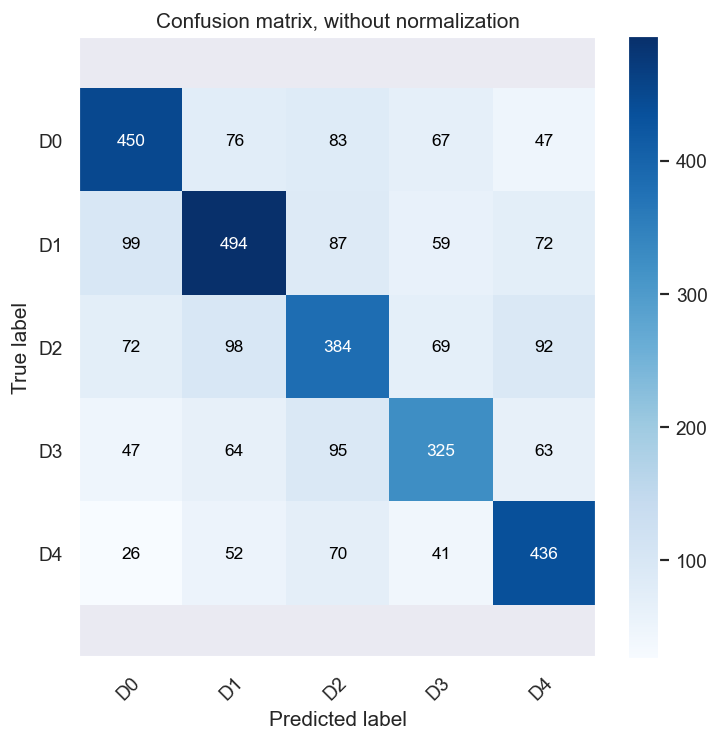

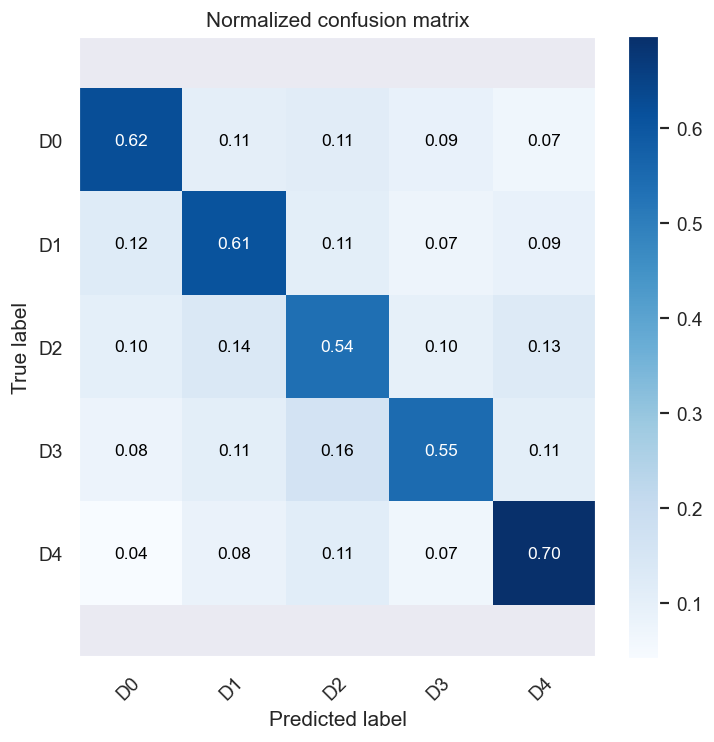

In [61]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_2_test, clf.predict(X_2_test),
                      title='Confusion matrix, without normalization')
plt.grid(False)

# plt.savefig("fig10.png")

# Plot normalized confusion matrix
plot_confusion_matrix(y_2_test, clf.predict(X_2_test), normalize=True,
                      title='Normalized confusion matrix')
plt.grid(False)

# plt.savefig("fig11.png")

plt.show()